# Descente de gradient 

Au cours de la séance précédente, nous avons vu deux méthodes différentes pour trouver le jeu de paramètres qui minimise la MSE, c'est à dire pour trouver la meilleure calibration de notre droite de régression. 

Aujourd'hui nous allons étudier une troisième méthode, plus adaptée pour les larges jeux de données, en particulier à plusieurs dimension : **la descente de gradient**.

Cette technique est fondamentale, non seulement pour la régression linéaire mais dans un grand nombre d'algorithmes de machine learning. 

In [1]:
%load_ext autoreload
import numpy as np 
import matplotlib.pyplot as plt
from utils import generate_tree_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Génération du jeu de données

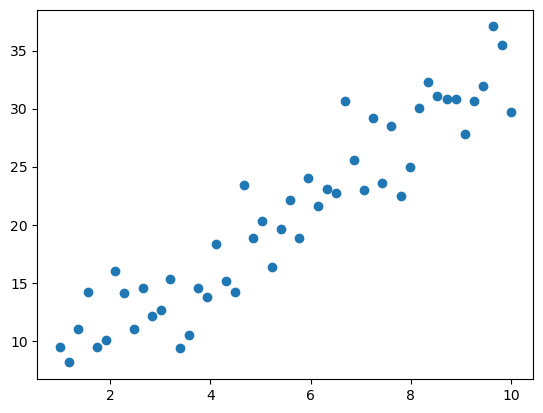

In [2]:
X, y = generate_tree_dataset(slope=3, intercept=5)

plt.scatter(X, y);

Rappel, forme de la fonction de coût :

- convexe
- ellipses concentriques

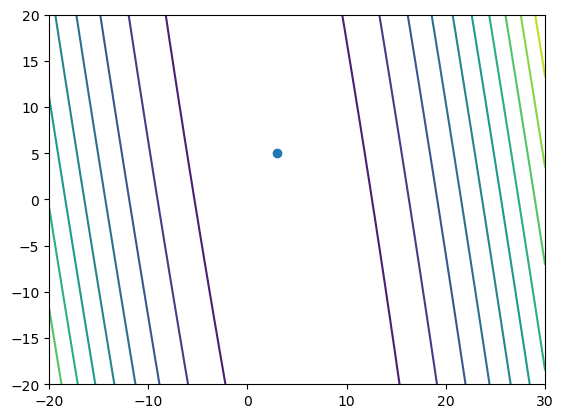

In [3]:
from utils import generate_mse_grid

# grille de paramètres
intercept_vals = np.linspace(-20, 20, 100)
slope_vals = np.linspace(-20, 30, 100)
X, y = generate_tree_dataset(slope=3, intercept=5)

MSE_grid = generate_mse_grid(X, y, intercept_vals, slope_vals)

plt.contour(slope_vals, intercept_vals, MSE_grid, levels=10)
plt.scatter(3, 5);

Pour améliorer la lisibilité, on centre et on réduit les données avec un [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), ce qui permet d'avoir des ellipses plus "arrondies". 

$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

X, y = generate_tree_dataset(slope=3, intercept=5, add_constant=False)
pipe = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))

pipe.fit(X, y)

a_hat, b_hat = pipe[-1].coef_[0], pipe[-1].intercept_

print("Coefficients estimés sur les données standardisées : ")
print("a : {:.2f}\nb : {:.2f}".format(a_hat, b_hat))

Coefficients estimés sur les données standardisées : 
a : 7.44
b : 20.82


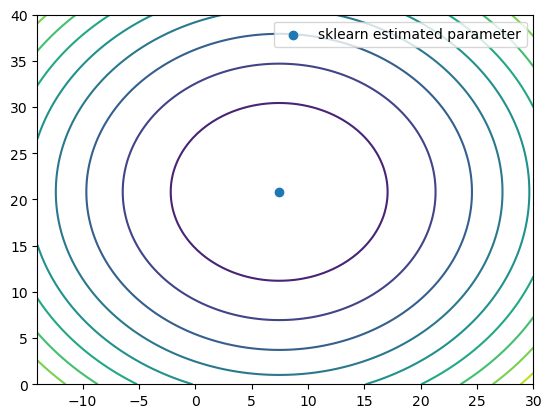

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
slope_vals = np.linspace(-14, 30, 100)
intercept_vals = np.linspace(0, 40, 100)

MSE_grid = generate_mse_grid(X_scaled, y, intercept_vals, slope_vals)

plt.contour(slope_vals, intercept_vals, MSE_grid, levels=10)
plt.scatter(a_hat, b_hat, label="sklearn estimated parameter")
plt.legend();

# 1. Fonctionnement de la descente de gradient 

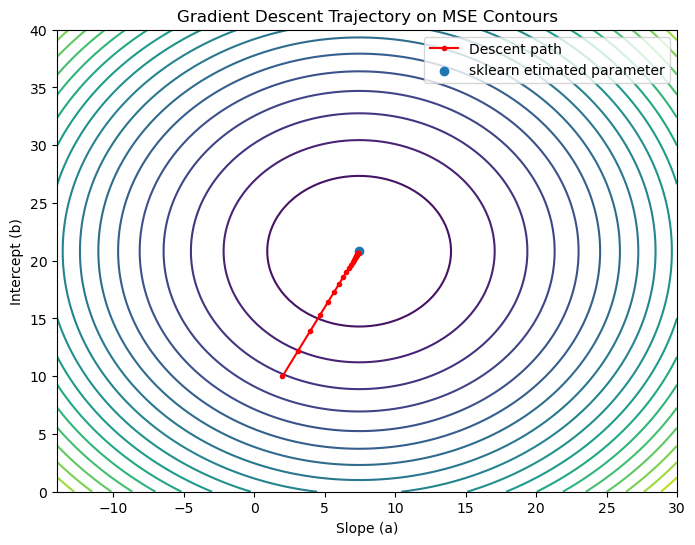

In [6]:
from utils import gradient_mse, gradient_descent

# Run gradient descent
it_hist, grad_hist = gradient_descent(
    gradient_mse, 
    X_scaled, y, 
    initial_condition=(2, 10), 
    lr=0.1, 
    n=20
)

# Extract trajectory of a (slope) and b (intercept)
a_hist = [a for a, b in it_hist]
b_hist = [b for a, b in it_hist]

# Plot contour + trajectory
plt.figure(figsize=(8, 6))
plt.contour(slope_vals, intercept_vals, MSE_grid, levels=20, cmap="viridis")

# Trajectory of gradient descent
plt.plot(a_hist, b_hist, marker="o", color="red", markersize=3, linewidth=1.5, label="Descent path")
plt.scatter(a_hat, b_hat, label="sklearn etimated parameter")
plt.xlabel("Slope (a)")
plt.ylabel("Intercept (b)")
plt.title("Gradient Descent Trajectory on MSE Contours")
plt.legend()
plt.show()

Entrées :
- f(θ) : fonction de coût
- ∇f(θ) : gradient de f
- θ₀ : condition initiale
- η : learning rate
- N : nombre d’itérations

Algorithme :
1. Initialiser θ ← θ₀
2. Pour t = 1 → N :
   - Calculer g ← ∇f(θ)
   - Mettre à jour θ ← θ - η * g
3. Retourner θ


# 2. Influence des hyperparmètres

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider, IntSlider

def plot_gradient_descent(a0, b0, lr, n):
    # Condition initiale
    initial_condition = (a0, b0)
    
    # Calcul du gradient descent
    it_hist, grad_hist = gradient_descent(
        gradient_mse, X_scaled, y,
        initial_condition=initial_condition,
        lr=lr,
        n=n
    )
    
    # Historique des paramètres
    a_hist = np.array([a for a, b in it_hist])
    b_hist = np.array([b for a, b in it_hist])
    
    # Norme du gradient
    grad_hist = np.array(grad_hist)

    grad_norm = np.linalg.norm(grad_hist, axis=1)
    
    # Itérations
    traj_iterations = np.arange(len(a_hist))      # pour la trajectoire
    grad_iterations = np.arange(len(grad_norm))   # pour le gradient
    
    # Subplots 2x2
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    
    # --- Graphe 1: Trajectoire sur les contours ---
    CS = ax[0, 0].contour(slope_vals, intercept_vals, MSE_grid, levels=30, cmap="viridis")
    ax[0, 0].clabel(CS, inline=1, fontsize=8)
    sc = ax[0, 0].scatter(a_hist, b_hist, c=traj_iterations, cmap='plasma', s=50, label="Descent path")
    ax[0, 0].plot(a_hist, b_hist, color='gray', linewidth=1, alpha=0.5)
    #ax[0, 0].scatter(a_hat, b_hat, label="sklearn estimated parameter", color="blue")
    ax[0, 0].set_xlabel("Slope (a)")
    ax[0, 0].set_ylabel("Intercept (b)")
    ax[0, 0].set_title("Gradient Descent Trajectory")
    fig.colorbar(sc, ax=ax[0, 0], label="Iteration")
    ax[0, 0].legend()
    
    # --- Graphe 2: Historique du gradient ---
    ax[0, 1].plot(grad_iterations, grad_norm, marker='o', color='red')
    ax[0, 1].set_xlabel("Iteration")
    ax[0, 1].set_ylabel("Gradient Norm")
    ax[0, 1].set_title("Gradient Magnitude per Iteration")
    
    # --- Graphe 3: a (slope) au fil du temps ---
    ax[1, 0].plot(traj_iterations, a_hist, marker='o', color='green')
    ax[1, 0].set_xlabel("Iteration")
    ax[1, 0].set_ylabel("Slope (a)")
    ax[1, 0].set_title("Slope Evolution over Time")
    
    # --- Graphe 4: b (intercept) au fil du temps ---
    ax[1, 1].plot(traj_iterations, b_hist, marker='o', color='orange')
    ax[1, 1].set_xlabel("Iteration")
    ax[1, 1].set_ylabel("Intercept (b)")
    ax[1, 1].set_title("Intercept Evolution over Time")
    
    plt.tight_layout()
    plt.show();

# Widgets interactifs
interact(
    plot_gradient_descent,
    a0=FloatSlider(value=2, min=-10, max=10, step=0.1, description="Initial slope (a0)"),
    b0=FloatSlider(value=10, min=-10, max=10, step=0.1, description="Initial intercept (b0)"),
    lr=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description="Learning rate"),
    n=IntSlider(value=20, min=1, max=100, step=1, description="Iterations")
);


interactive(children=(FloatSlider(value=2.0, description='Initial slope (a0)', max=10.0, min=-10.0), FloatSlid…

<p align="center">
  <img src="./img/gd_lr_impact.png" alt="plot" width="50%"/>
</p>

source : Dieuleveut

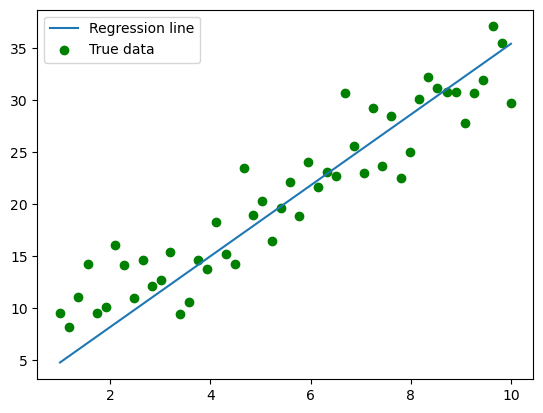

In [30]:
X, y = generate_tree_dataset(slope=3, intercept=5, add_constant=False)
iteration_hist, _ = gradient_descent(gradient_mse, X, y, n=50)
a_hat, b_hat = iteration_hist[-1]

plt.plot(X, a_hat * X + b_hat, label="Regression line")
plt.scatter(X, y, label="True data", color="green")
plt.legend();

# 3. Un exemple sur des données arbitraires

Importance du scaling des données 

In [31]:
from drawdata import ScatterWidget

widget = ScatterWidget()
widget

ScatterWidget()

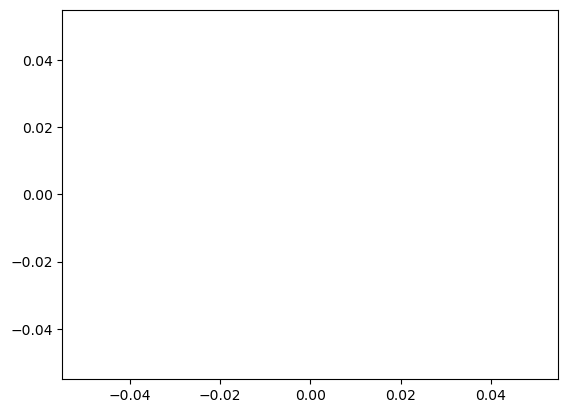

In [32]:
X, y = widget.data_as_X_y
plt.scatter(X, y);

Test de notre algo de descente de gradient 

In [33]:
iteration_hist, derivation_hist = gradient_descent(derivative=gradient_mse,
                                                   x=X, y=y,lr=0.01, n=100,
                                                   initial_condition=(100, 200))
a_hat, b_hat = iteration_hist[-1]

plt.plot(X, a_hat * X + b_hat, label="Regression line")
plt.scatter(X, y, label="True data", color="green")
plt.title("Estimation : {:.2f} et {:.2f}".format(a_hat, b_hat))
plt.legend();

ZeroDivisionError: float division by zero

Diagnostic : le gradient explose dès le départ 

/home/basile/.conda/envs/base_ds/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2832: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


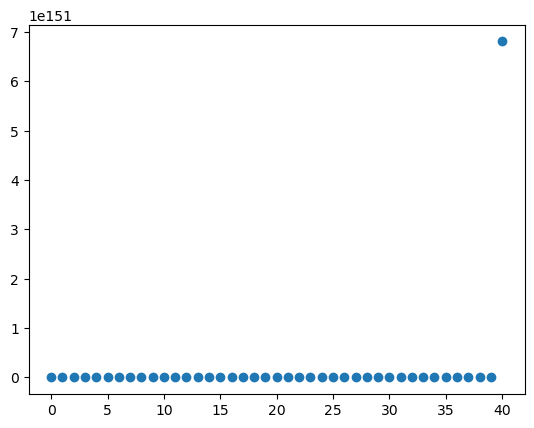

In [ ]:
grad_norm = np.linalg.norm(np.array(derivation_hist), axis=1)
n = grad_norm.shape[0]
plt.scatter(np.arange(n, dtype=int), grad_norm)

Une solution est de centrer réduire les données pour réduire l'instabilité numérique.

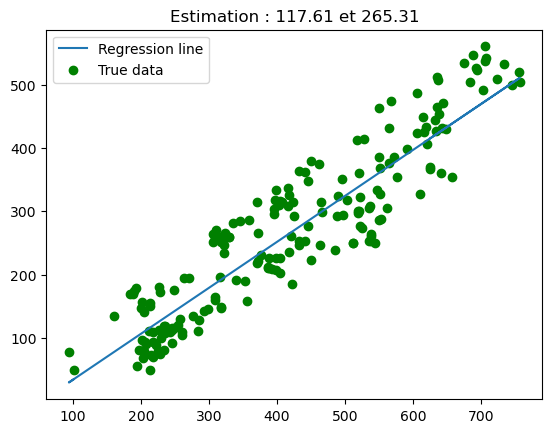

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iteration_hist, gradient_hist = gradient_descent(gradient_mse, X_scaled, y, n=200)
a_hat, b_hat = iteration_hist[-1]

plt.plot(X, a_hat * scaler.transform(X) + b_hat, label="Regression line")
plt.scatter(X, y, label="True data", color="green")
plt.title("Estimation : {:.2f} et {:.2f}".format(a_hat, b_hat))
plt.legend();

On peut ajuster n itérations en regardant la magnitude du vecteur. 

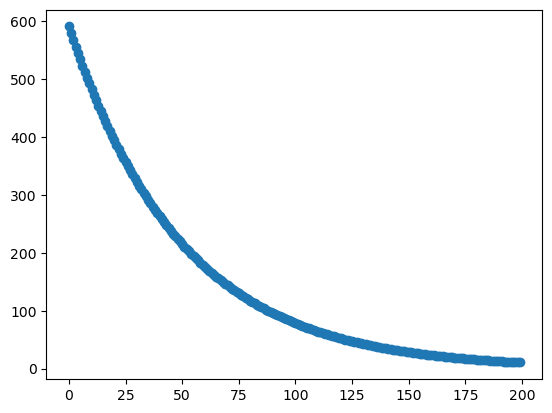

In [ ]:
grad_norm = np.linalg.norm(np.array(gradient_hist), axis=1)
n = grad_norm.shape[0]
plt.scatter(np.arange(n, dtype=int), grad_norm);

Visiblement on a atteint le bon minimum. Cet algorithme est le plsu utilisé en pratique car les autres solutions nécessitent de stocker et d'inverser une matrice potentiellement très grosse. Dans le cas d'une régression linéaire, la fonction de coût est convexe mais des variantes de l'algorithme peuvent exister (batch, stochastich, avec gravité, learning rate adaptatif ...)

> Maintenant que l'on a vu comment bien paramètrer un modèle de régression linéaire, l'enjeu est de pouvoir l'utiliser et de s'assurer qu'il est performant. Ce sera l'objet du cours de demain : **évaluer la pertinence et interpréter un modèle linéaire**

Ressources : 

- Cette [excellente vidéo](https://www.youtube.com/watch?v=IHZwWFHWa-w) de 3 Blue 1 Brown, toute la chaîne vaut le détour
- L'idée du widget vient de [cette vidéo](https://www.youtube.com/watch?v=yLz1NELcIM0) de Probabl, un spin-off de scikit-learn qui diffuse des vidéos d'explication sur le ML
- La documentation de scikit-learn est très bien faite

- Toujours dans le registre des vidéos Youtube, vous pouvez aller voir : 
  - 3Blue1Brown
  - MachineLearnia
  - Statquest